# Load Libraries


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import Callback

In [2]:
import os
import random

# Set random seeds for reproducibility
def set_random_seed(seed=31):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Set the random seed
set_random_seed(31)

# Load Data


In [3]:
# Membaca data dari direktori input di Kaggle
df_train = pd.read_csv('/kaggle/input/suhu-udara-jumantono/df_train.csv')
df_test = pd.read_csv('/kaggle/input/suhu-udara-jumantono/df_test.csv')

# # Membaca data dari direktori input di local
# df_train = pd.read_csv('df_train.csv')
# df_test = pd.read_csv('df_test.csv')

# Mengonversi kolom Tanggal ke format datetime jika belum
df_train['Tanggal'] = pd.to_datetime(df_train['Tanggal'])
df_test['Tanggal'] = pd.to_datetime(df_test['Tanggal'])

# Menambahkan kolom Suhu Udara Rata-Rata (˚C) ke df_train dengan rumus yang diberikan
df_train['Suhu Udara (˚C) Rata-Rata'] = (2 * df_train['Suhu Udara (˚C) 07.00'] + 
                                         df_train['Suhu Udara (˚C) 13.00'] + 
                                         df_train['Suhu Udara (˚C) 18.00']) / 4

# Menambahkan kolom Suhu Udara Rata-Rata (˚C) ke df_test dengan rumus yang sama
df_test['Suhu Udara (˚C) Rata-Rata'] = (2 * df_test['Suhu Udara (˚C) 07.00'] + 
                                        df_test['Suhu Udara (˚C) 13.00'] + 
                                        df_test['Suhu Udara (˚C) 18.00']) / 4

In [4]:
# # Columns to plot
# columns_to_plot = df_train.columns.difference(['Tanggal']).tolist()

# # Loop through each column and create a separate plot
# for column in columns_to_plot:
#     plt.figure(figsize=(12, 6))
    
#     # Plot df_train for the current column
#     plt.plot(df_train['Tanggal'], df_train[column], label=f'Training Data - {column}', linestyle='-')
    
#     # Plot df_test for the current column
#     plt.plot(df_test['Tanggal'], df_test[column], label=f'Testing Data - {column}', linestyle='--')
    
#     # Adding titles and labels
#     plt.title(f'Training and Testing Data Line Chart - {column}')
#     plt.xlabel('Tanggal')
#     plt.ylabel('Temperature')
#     plt.legend()
    
#     # Display the plot
#     plt.show()

# Load Function


In [5]:
def root_mean_squared_error(y_true, y_pred):
    """
    Fungsi untuk menghitung Root Mean Squared Error (RMSE).
    
    Args:
    y_true: Array atau daftar nilai asli (target sebenarnya).
    y_pred: Array atau daftar nilai peramalan.
    
    Returns:
    RMSE sebagai nilai kesalahan.
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Fungsi untuk menghitung Mean Absolute Percentage Error (MAPE).
    
    Args:
    y_true: Array atau daftar nilai asli (target sebenarnya).
    y_pred: Array atau daftar nilai peramalan.
    
    Returns:
    MAPE dalam persentase.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
def plot_predictions(df_test, y_true, y_pred, input_feature, title_template="{input_feature} di Jumantono 1 Januari 2024 - 31 Juli 2024"):
    """
    Fungsi untuk memvisualisasikan y_true vs y_pred dengan sumbu x sebagai df_test.index
    
    Args:
    df_test: DataFrame yang memiliki indeks (digunakan sebagai sumbu x).
    y_true: Nilai target aktual (nilai sebenarnya).
    y_pred: Hasil peramalan yang telah dinormalisasi.
    input_feature: Nama fitur input yang digunakan untuk judul grafik.
    title_template: Template judul grafik dengan {input_feature} sebagai placeholder.
    
    Returns:
    Grafik visualisasi perbandingan peramalan vs aktual.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot y_true (target asli)
    plt.plot(df_test.index[:len(y_true)], y_true, label="Aktual", color='blue')
    
    # Plot y_pred (hasil peramalan)
    plt.plot(df_test.index[:len(y_pred)], y_pred, label="Peramalan", color='red', linestyle='--')
    
    # Membuat judul dari template dengan input_feature
    title = title_template.format(input_feature=input_feature)
    plt.title(title)
    
    # Menambahkan label dan legenda
    plt.xlabel('Waktu')
    plt.ylabel('Nilai')
    
    plt.legend()
    
    # Tampilkan grafik
    plt.grid(True)
    plt.show()

In [8]:
# Fungsi untuk menampilkan grafik training loss tanpa val_loss
def plot_loss(history, model_number):
    loss = history.history['loss']
    
    # Plot training loss
    plt.plot(loss, label=f'Model {model_number} Training Loss')
    
    plt.title(f'Training Loss for MLP Model {model_number}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [9]:
class CustomEarlyStopping(Callback):
    def __init__(self, patience=3, min_delta=0.0002, restore_best_weights=True):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.best_loss = float('inf')
        self.counter = 0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        if current_loss is None:
            return

        # Check if loss has improved by at least `min_delta`
        if self.best_loss - current_loss > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered at epoch {epoch + 1}.")
                self.model.stop_training = True
                if self.restore_best_weights and self.best_weights is not None:
                    self.model.set_weights(self.best_weights)

# Pre-processing


In [10]:
df_train.set_index('Tanggal', inplace=True)
df_test.set_index('Tanggal', inplace=True)

## Uji Korelasi Lag


In [11]:
# import pandas as pd

# # Membuat dataframe baru untuk menyimpan hasil korelasi
# correlation_results = pd.DataFrame()

# # Loop untuk setiap kolom numerik di df_train
# for column in df_train.select_dtypes(include=['float64', 'int64']).columns:
#     # Loop untuk menghitung korelasi dengan berbagai lag (misalnya dari 1 hingga 365 periode sebelumnya)
#     for lag in range(1, len(df_train)-2):
#         # Menggeser data df_train berdasarkan lag
#         df_corr = df_train.copy()
#         df_corr[f'{column}_lag_{lag}'] = df_train[column].shift(lag)
        
#         # Menghitung korelasi antara kolom saat ini dan lag-nya
#         corr = df_corr[[column, f'{column}_lag_{lag}']].corr().iloc[0, 1]
        
#         # Menyimpan hasil korelasi ke dataframe hasil dengan kolom sesuai nama feature
#         correlation_results.loc[lag, column] = corr

In [12]:
# # Menampilkan hasil korelasi
# correlation_results
# import matplotlib.pyplot as plt

# # Membuat barchart untuk setiap feature dan lag
# for column in correlation_results.columns:
#     plt.figure(figsize=(10, 6))
#     plt.bar(correlation_results.index, correlation_results[column])
#     plt.title(f'Korelasi Lag untuk {column}')
#     plt.xlabel('Lag')
#     plt.ylabel('Korelasi')
#     plt.xticks(rotation=90)
#     plt.tight_layout()
#     plt.show()

## Sliding Window


In [13]:
def create_sliding_window_dataset_with_horizon(X, y, WINDOW_SIZE, HORIZON, BATCH_SIZE):
    """
    Creates a sliding window dataset with forecasting HORIZON.
    
    Parameters:
    - X: DataFrame atau array dari input features.
    - y: DataFrame atau array dari target features.
    - WINDOW_SIZE: Ukuran window untuk input.
    - HORIZON: Jarak waktu ke depan untuk peramalan.
    - BATCH_SIZE: Ukuran batch untuk pelatihan model.
    - SHUFFLE_BUFFER: Buffer ukuran untuk shuffle saat training.
    - is_training: Jika True, dataset akan di-shuffle.
    """
    # Konversi ke TensorFlow dataset
    input_series = tf.data.Dataset.from_tensor_slices(X.values)
    target_series = tf.data.Dataset.from_tensor_slices(y.values)

    # Buat window dari input dan target
    input_window = input_series.window(WINDOW_SIZE, shift=1, drop_remainder=True)
    target_window = target_series.window(WINDOW_SIZE + HORIZON, shift=1, drop_remainder=True)

    # Mengubah window menjadi batch
    input_window = input_window.flat_map(lambda window: window.batch(WINDOW_SIZE))
    target_window = target_window.flat_map(lambda window: window.batch(WINDOW_SIZE + HORIZON))

    # Gabungkan fitur (input) dan target
    dataset = tf.data.Dataset.zip((input_window, target_window))

    # Pisahkan input (X) dan label (y) dengan horizon untuk peramalan
    dataset = dataset.map(lambda X, y: (X, y[-HORIZON:]))  # Mengambil horizon terakhir dari target sebagai label
    
    # Batch the dataset
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)

    return dataset

# Modelling


## Parameter


In [14]:
WINDOW_SIZE = 365
HORIZON = 153
BATCH_SIZE = 2
SHUFFLE_BUFFER = 365
EPOCHS = 100
PATIENCES = 5

## Build Model


In [15]:
def build_mlp_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(input_shape),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
                
        tf.keras.layers.Dense(HORIZON)
    ])
    
    # Compile with RMSE and MAPE
    model.compile(
        optimizer=tf.keras.optimizers.Adam(), 
        loss=tf.keras.losses.MeanSquaredError(), 
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )
    return model

In [16]:
# def build_mlp_model(input_shape):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Input(input_shape),

#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(512, activation='relu'),
#         tf.keras.layers.Dense(256, activation='relu'),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(64, activation='relu'),
                
#         tf.keras.layers.Dense(HORIZON)
#     ])
    
#     # Compile with RMSE and MAPE
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(), 
#         loss=tf.keras.losses.MeanSquaredError(), 
#         metrics=[
#             tf.keras.metrics.RootMeanSquaredError(),
#             tf.keras.metrics.MeanAbsolutePercentageError()
#         ]
#     )
#     return model

## Train Model


In [17]:
# Daftar semua fitur dalam dataset
all_features = df_train.columns.tolist()

# Definisikan target features
# target_features = df_train.columns.difference(['Tanggal']).tolist()

# features = ['Suhu Udara (˚C) 07.00', 'Suhu Udara (˚C) 13.00', 'Suhu Udara (˚C) 18.00', 'Suhu Udara (˚C) Rata-Rata']

target_features = ['Suhu Udara (˚C) Rata-Rata']



Training MLP Model 1 for 
Target Feature: Suhu Udara (˚C) Rata-Rata 
Input Feature: Suhu Udara (˚C) Rata-Rata
X_batch shape: (2, 365, 1)
y_batch shape: (2, 153, 1)
Epoch 1/100


I0000 00:00:1732973594.750236      68 service.cc:145] XLA service 0x7eceac01fcf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732973594.750288      68 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732973594.750294      68 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732973598.511874      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


655/655 - 12s - 18ms/step - loss: 0.0223 - mean_absolute_percentage_error: 296986.5625 - root_mean_squared_error: 0.1492
Epoch 2/100
655/655 - 2s - 3ms/step - loss: 0.0137 - mean_absolute_percentage_error: 306888.5000 - root_mean_squared_error: 0.1169
Epoch 3/100
655/655 - 2s - 3ms/step - loss: 0.0136 - mean_absolute_percentage_error: 315844.2188 - root_mean_squared_error: 0.1167
Epoch 4/100
655/655 - 2s - 3ms/step - loss: 0.0137 - mean_absolute_percentage_error: 323393.9688 - root_mean_squared_error: 0.1169
Epoch 5/100
655/655 - 2s - 3ms/step - loss: 0.0138 - mean_absolute_percentage_error: 328192.7500 - root_mean_squared_error: 0.1175
Epoch 6/100
655/655 - 2s - 3ms/step - loss: 0.0137 - mean_absolute_percentage_error: 332751.4375 - root_mean_squared_error: 0.1170
Epoch 7/100
Early stopping triggered at epoch 7.
655/655 - 2s - 3ms/step - loss: 0.0139 - mean_absolute_percentage_error: 336065.6875 - root_mean_squared_error: 0.1181


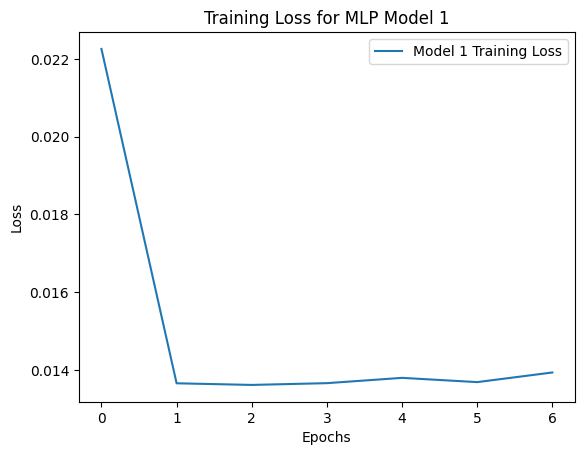

In [18]:
# Inisialisasi model_counter dan dictionary untuk model, history, dan scaler
model_counter = 1
models = {}  # Dictionary untuk menyimpan model
histories = {}  # Dictionary untuk menyimpan history training
scalers = {}  # Dictionary untuk menyimpan scaler

# Iterasi untuk setiap target feature
for target_feature in target_features:
    # Daftar input features kecuali target feature saat ini
    input_feature = target_feature

    print(f"Training MLP Model {model_counter} for \nTarget Feature: {target_feature} \nInput Feature: {input_feature}")

    # Buat dataset dengan input satu fitur dan target tetap satu fitur
    X_train = df_train[[input_feature]]
    y_train = df_train[[target_feature]]

    # Normalisasi data dengan MinMaxScaler baru untuk setiap model
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Fit and transform untuk input feature dan target feature
    X_train_normalized = scaler_X.fit_transform(X_train)
    y_train_normalized = scaler_y.fit_transform(y_train)

    # Simpan scaler untuk X_train dan y_train ke dalam dictionary scalers
    scalers[f"scaler_X_{model_counter}"] = scaler_X
    scalers[f"scaler_y_{model_counter}"] = scaler_y

    # Buat DataFrame dari data yang sudah dinormalisasi
    X_train_normalized_df = pd.DataFrame(X_train_normalized, 
                                            index=X_train.index, 
                                            columns=X_train.columns)
    y_train_normalized_df = pd.DataFrame(y_train_normalized, 
                                            index=y_train.index, 
                                            columns=y_train.columns)

    # Buat dataset dengan sliding window dari data yang dinormalisasi
    train_dataset = create_sliding_window_dataset_with_horizon(
        X_train_normalized_df, y_train_normalized_df, 
        WINDOW_SIZE, HORIZON, BATCH_SIZE)
    
    for X_batch, y_batch in train_dataset.take(1):
        print("X_batch shape:", X_batch.shape)
        print("y_batch shape:", y_batch.shape)

    # Build dan simpan model dalam dictionary
    model = build_mlp_model((WINDOW_SIZE, ))
    models[f"mlp_model_{model_counter}"] = model
    
    # # Early stopping untuk menghentikan training jika tidak ada peningkatan
    # early_stopping = EarlyStopping(monitor='loss', 
    #                                 patience=PATIENCES, 
    #                                 restore_best_weights=True)

    # Tambahkan callback CustomEarlyStopping
    early_stopping = CustomEarlyStopping(patience=PATIENCES, min_delta=0.0001, restore_best_weights=True)

    # Fit model dan simpan history dalam dictionary
    history = model.fit(train_dataset, epochs=EPOCHS, verbose=2, callbacks=[early_stopping])
    histories[f"history_{model_counter}"] = history
    
    # Tampilkan grafik loss untuk model saat ini (hanya training loss)
    plot_loss(history, model_counter)

    # Increment model_counter
    model_counter += 1

    print("")  # Tambahan untuk spasi antara output model

## Evaluate Model


Evaluating MLP Model 1 for 
Target Feature: Suhu Udara (˚C) Rata-Rata 
Input Feature: Suhu Udara (˚C) Rata-Rata
HORIZON (153) < len(df_test) (213) - Using Rolling Evaluation
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


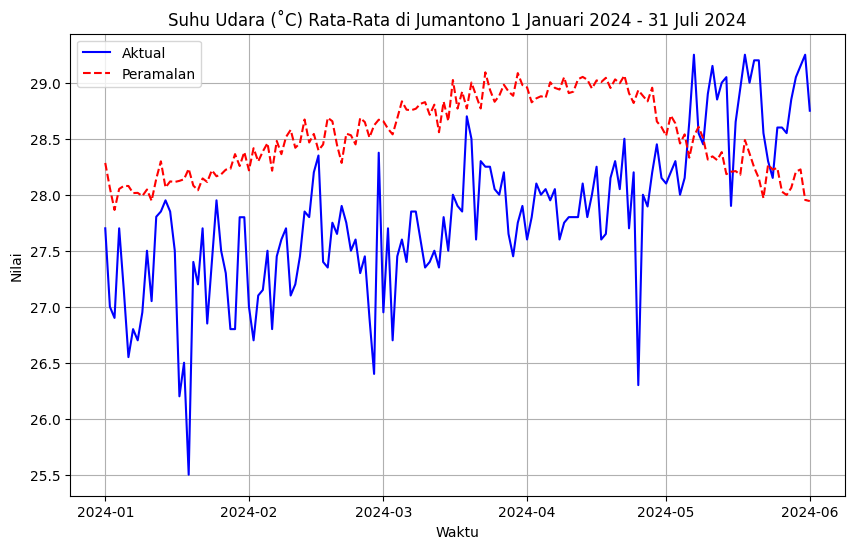

Model 1 -> RMSE: 1.0255, MAPE: 3.32%



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        23,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 153)            │         9,945 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,017,997 (19.14 MB)

 Trainable params: 1,672,665 (6.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,345,332 (12.76 MB)

None


,target_feature,input_feature,rmse,mape
0,Suhu Udara (˚C) Rata-Rata,Suhu Udara (˚C) Rata-Rata,1.025513,3.322501


In [19]:
# Inisialisasi model_counter untuk evaluasi
model_counter = 1
evaluation_metrics = {
    'target_feature': [],
    'input_feature': [],
    'rmse': [],
    'mape': []
}

# Looping untuk setiap target feature dan input feature
for target_feature in target_features:
    input_feature = target_feature

    print(f"Evaluating MLP Model {model_counter} for \nTarget Feature: {target_feature} \nInput Feature: {input_feature}")

    # Mengambil scaler_X dan scaler_y dari dictionary scalers
    scaler_X = scalers[f"scaler_X_{model_counter}"]
    scaler_y = scalers[f"scaler_y_{model_counter}"]

    # Kondisi untuk memutuskan rolling atau full horizon evaluation
    if HORIZON >= len(df_test[target_feature]):
        print(f"HORIZON ({HORIZON}) >= len(df_test) ({len(df_test[target_feature])}) - Using Full Horizon Evaluation")

        # Full horizon evaluation
        X_test = df_test[[input_feature]]
        y_test = df_test[[target_feature]]

        # Tambahkan data dari training ke test untuk sliding window
        extra_train_data = df_train[[input_feature]].iloc[-(WINDOW_SIZE + HORIZON - len(df_test)):]
        
        X_test_combined = pd.concat([extra_train_data, df_test[[input_feature]]], axis=0)
        y_test_combined = pd.concat([df_train[[target_feature]].iloc[-(WINDOW_SIZE + HORIZON - len(df_test)):], df_test[[target_feature]]], axis=0)

        # Normalisasi data
        X_test_combined_normalized = scaler_X.transform(X_test_combined)
        y_test_combined_normalized = scaler_y.transform(y_test_combined)

        # Buat dataset untuk testing
        test_dataset = create_sliding_window_dataset_with_horizon(
            pd.DataFrame(X_test_combined_normalized, index=X_test_combined.index, columns=X_test_combined.columns),
            pd.DataFrame(y_test_combined_normalized, index=y_test_combined.index, columns=y_test_combined.columns),
            WINDOW_SIZE, HORIZON, BATCH_SIZE
        )

        # Prediksi pada dataset test
        y_pred_normalized_list = []
        model_name = f"mlp_model_{model_counter}"
        model = models.get(model_name)

        for X_batch, _ in test_dataset:
            y_pred_normalized_batch = model.predict(X_batch)
            y_pred_normalized_list.append(y_pred_normalized_batch)

        # Gabungkan hasil prediksi
        y_pred_normalized = np.concatenate(y_pred_normalized_list, axis=0)
        y_pred_denormalized = scaler_y.inverse_transform(y_pred_normalized).flatten()

        # Trim test set untuk menyamakan panjang dengan prediksi
        y_test_combined_trimmed = y_test_combined.iloc[WINDOW_SIZE + HORIZON - len(df_test):]
        y_test_actual = y_test_combined_trimmed.values.flatten()

        # Hitung metrik evaluasi
        rmse_value = root_mean_squared_error(y_test_actual, y_pred_denormalized)
        mape_value = mean_absolute_percentage_error(y_test_actual, y_pred_denormalized)

        # Simpan hasil evaluasi
        evaluation_metrics['target_feature'].append(target_feature)
        evaluation_metrics['input_feature'].append(input_feature)
        evaluation_metrics['rmse'].append(rmse_value)
        evaluation_metrics['mape'].append(mape_value)

        # Visualisasi
        title = f"{target_feature} di Jumantono 1 Januari 2024 - 31 Juli 2024"
        plot_predictions(df_test, y_test_actual, y_pred_denormalized, target_feature, title)

        print(f"Model {model_counter} -> RMSE: {rmse_value:.4f}, MAPE: {mape_value:.2f}%\n")

    else:
        print(f"HORIZON ({HORIZON}) < len(df_test) ({len(df_test[target_feature])}) - Using Rolling Evaluation")

        # Rolling evaluate
        rolling_rmse = []
        rolling_mape = []
        predictions = []
        actuals = []

        for start_idx in range(0, len(df_test), HORIZON):
            end_idx = start_idx + HORIZON
            if end_idx > len(df_test):
                break

            # Data train terakhir + data test sesuai horizon
            rolling_train = df_train[[input_feature]].iloc[-WINDOW_SIZE:].copy()
            rolling_test = df_test[[input_feature]].iloc[start_idx:end_idx].copy()
            rolling_target = df_test[[target_feature]].iloc[start_idx:end_idx].copy()

            # Menggabungkan data rolling
            X_test_combined = pd.concat([rolling_train, rolling_test], axis=0)
            y_test_combined = pd.concat([df_train[[target_feature]].iloc[-WINDOW_SIZE:], rolling_target], axis=0)

            # Normalisasi data
            X_test_combined_normalized = scaler_X.transform(X_test_combined)
            y_test_combined_normalized = scaler_y.transform(y_test_combined)

            # Buat dataset untuk testing
            test_dataset = create_sliding_window_dataset_with_horizon(
                pd.DataFrame(X_test_combined_normalized, index=X_test_combined.index, columns=X_test_combined.columns),
                pd.DataFrame(y_test_combined_normalized, index=y_test_combined.index, columns=y_test_combined.columns),
                WINDOW_SIZE, HORIZON, BATCH_SIZE
            )

            # Prediksi pada dataset test
            y_pred_normalized_list = []
            for X_batch, _ in test_dataset:
                y_pred_normalized_batch = model.predict(X_batch)
                y_pred_normalized_list.append(y_pred_normalized_batch)

            # Gabungkan hasil prediksi
            y_pred_normalized = np.concatenate(y_pred_normalized_list, axis=0)
            y_pred_denormalized = scaler_y.inverse_transform(y_pred_normalized).flatten()

            # Nilai target aktual
            y_actual = rolling_target.values.flatten()

            # Simpan hasil prediksi dan aktual
            predictions.extend(y_pred_denormalized[:len(y_actual)])
            actuals.extend(y_actual)

            # Hitung metrik evaluasi
            rmse_value = root_mean_squared_error(y_actual, y_pred_denormalized[:len(y_actual)])
            mape_value = mean_absolute_percentage_error(y_actual, y_pred_denormalized[:len(y_actual)])

            rolling_rmse.append(rmse_value)
            rolling_mape.append(mape_value)

        # Hitung metrik keseluruhan
        overall_rmse = root_mean_squared_error(actuals, predictions)
        overall_mape = mean_absolute_percentage_error(actuals, predictions)

        # Simpan hasil evaluasi
        evaluation_metrics['target_feature'].append(target_feature)
        evaluation_metrics['input_feature'].append(input_feature)
        evaluation_metrics['rmse'].append(overall_rmse)
        evaluation_metrics['mape'].append(overall_mape)

        # Visualisasi
        title = f"{target_feature} di Jumantono 1 Januari 2024 - 31 Juli 2024"
        plot_predictions(df_test, actuals, predictions, target_feature, title)

        print(f"Model {model_counter} -> RMSE: {overall_rmse:.4f}, MAPE: {overall_mape:.2f}%\n")

    print(model.summary())

    # Increment model_counter
    model_counter += 1
# Tampilkan hasil evaluasi secara keseluruhan
import pandas as pd
df_evaluation = pd.DataFrame(evaluation_metrics)

df_evaluation


# Forecast


In [20]:
import numpy as np
import pandas as pd

# Inisialisasi dictionary untuk menyimpan hasil peramalan
future_predictions = {
    'Target Feature': [],
    'Input Feature': [],
    'Forecast Dates': [],
    'Forecast Values': []
}

# Definisikan range waktu untuk peramalan Agustus 2024 - Desember 2024
future_dates = pd.date_range(start='2024-08-01', end='2024-12-31')

# Looping untuk setiap target feature dan input feature
model_counter = 1
for target_feature in target_features:
    input_feature = target_feature
        
    print(f"Predicting future data for MLP Model {model_counter} for \nTarget Feature: {target_feature} \nInput Feature: {input_feature}")

    # Mengambil model yang sudah dilatih
    model_name = f"mlp_model_{model_counter}"
    model = models.get(model_name)
    
    # Mengambil scaler_X dan scaler_y dari dictionary scalers
    scaler_X = scalers[f"scaler_X_{model_counter}"]
    scaler_y = scalers[f"scaler_y_{model_counter}"]

    # Ambil data suhu dari bulan Juli 2024 sebagai input awal untuk peramalan masa depan
    X_future = df_test[[input_feature]].iloc[-WINDOW_SIZE:]
    
    # Tambahkan lebih banyak data dari training ke test untuk sliding window
    extra_data_X = df_train[[input_feature]].iloc[-WINDOW_SIZE:]

    # Gabungkan data training dan testing, ambil WINDOW_SIZE terakhir
    X_future_combined = pd.concat([extra_data_X, X_future], axis=0).iloc[-WINDOW_SIZE:]
    
    # Normalisasi input data menggunakan scaler_X
    X_future_normalized = scaler_X.transform(X_future_combined)

    # Peramalan langsung untuk seluruh horizon 213 sekaligus
    X_future_reshaped = X_future_normalized.reshape(1, WINDOW_SIZE, 1)  # reshape sesuai input layer
    print(X_future_reshaped.shape)
    y_pred_normalized = model.predict(X_future_reshaped)

    # Denormalisasi hasil peramalan
    y_pred_denormalized = scaler_y.inverse_transform(y_pred_normalized)
    y_pred_denormalized = y_pred_denormalized.flatten()[:153]

    # Simpan hasil peramalan untuk target feature dan input feature saat ini
    future_predictions['Target Feature'].append(target_feature)
    future_predictions['Input Feature'].append(input_feature)
    future_predictions['Forecast Dates'].append(future_dates)
    future_predictions['Forecast Values'].append(y_pred_denormalized.flatten().round(2))

    print("")
    
    # Increment model_counter
    model_counter += 1

# Mengonversi hasil peramalan ke DataFrame
df_future_predictions = pd.DataFrame({
    'Target Feature': future_predictions['Target Feature'],
    'Input Feature': future_predictions['Input Feature'],
    'Forecast Dates': future_predictions['Forecast Dates'],
    'Forecast Values': future_predictions['Forecast Values']
})

Predicting future data for MLP Model 1 for 
Target Feature: Suhu Udara (˚C) Rata-Rata 
Input Feature: Suhu Udara (˚C) Rata-Rata
(1, 365, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



In [21]:
# Creating individual DataFrames for each Input Feature
dfs = {}
for _, row in df_future_predictions.iterrows():
    input_feature = row['Input Feature']
    dfs[input_feature] = pd.DataFrame({
        'Forecast Dates': row['Forecast Dates'],
        'Forecast Values': row['Forecast Values']
    })

In [22]:
# forecast_suhu07_df = dfs['Suhu Udara (˚C) 07.00']
# forecast_suhu07_df

In [23]:
# forecast_suhu13_df = dfs['Suhu Udara (˚C) 13.00']
# forecast_suhu13_df

In [24]:
# forecast_suhu18_df = dfs['Suhu Udara (˚C) 18.00']
# forecast_suhu18_df

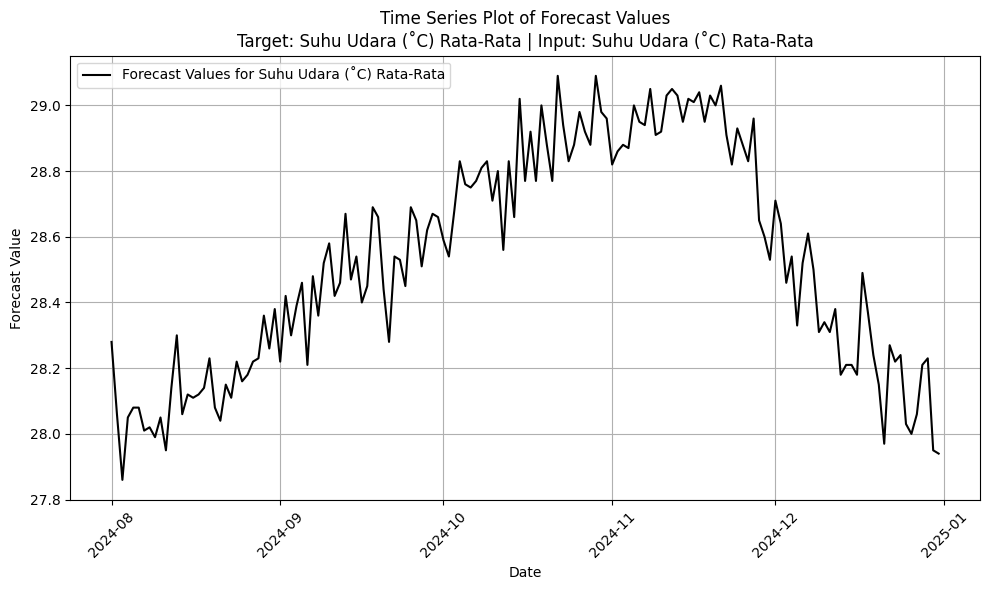

In [25]:
# Mengolah df_future_predictions agar peramalan bisa di-plot sesuai format yang benar
for i, row in df_future_predictions.iterrows():
    # Dates dan values harus di-flatten untuk plotting
    dates = row['Forecast Dates']
    values = np.array(row['Forecast Values']).flatten()
    
    # Pastikan dimensi dates dan values sama
    if len(dates) != len(values):
        values = values[:len(dates)]  # Potong nilai values agar sesuai dengan dates
    
    target_feature = row['Target Feature']
    input_feature = row['Input Feature']
    
    # Plot runtun waktu untuk setiap feature
    plt.figure(figsize=(10, 6))
    plt.plot(dates, values, label=f'Forecast Values for {target_feature}', color='black')
    plt.title(f'Time Series Plot of Forecast Values\nTarget: {target_feature} | Input: {input_feature}')
    plt.xlabel('Date')
    plt.ylabel('Forecast Value')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Full Plot


## Forecast Test


In [26]:
# Function to plot the time series with train, test, and predicted values
def plot_time_series_with_evaluation(df_train, df_test, y_test_actual, y_pred, input_feature, title="Time Series with Evaluation"):
    plt.figure(figsize=(14, 8))
    
    # Plot training data
    plt.plot(df_train.index, df_train[input_feature], label="Training Data", color='blue')
    
    # Plot true values in test data
    plt.plot(df_test.index[:len(y_test_actual)], y_test_actual, label="Test Actual", color='green')
    
    # Plot predicted values in test data
    plt.plot(df_test.index[:len(y_pred)], y_pred, label="Test Predicted", color='red', linestyle='--')
    
    # Set titles and labels
    plt.title(f"{title} - {input_feature}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()


Plotting Evaluation and Forecast for MLP Model 1 - Target Feature: Suhu Udara (˚C) Rata-Rata
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


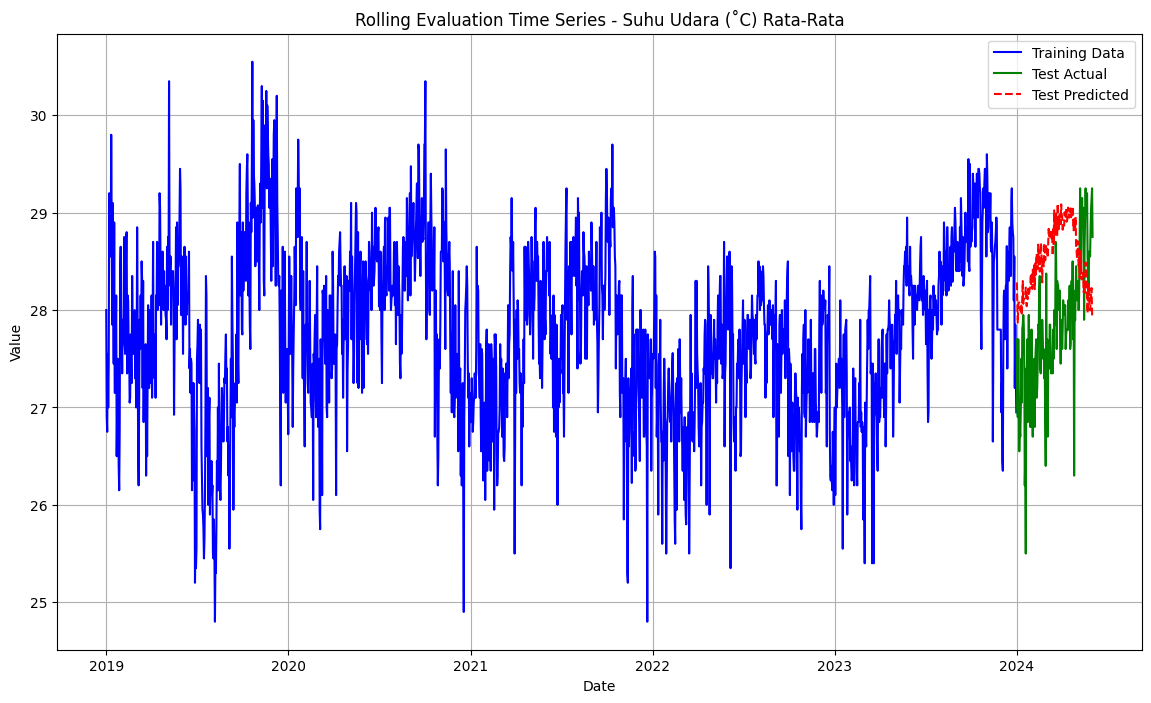

In [27]:
# Evaluation plot with test predictions
model_counter = 1
for target_feature in target_features:
    input_feature = target_feature

    print(f"Plotting Evaluation and Forecast for MLP Model {model_counter} - Target Feature: {target_feature}")

    # Rolling evaluation and plotting
    if HORIZON < len(df_test[target_feature]):
        rolling_predictions = []
        rolling_actuals = []

        for start_idx in range(0, len(df_test), HORIZON):
            end_idx = start_idx + HORIZON
            if end_idx > len(df_test):
                break

            # Rolling test data
            rolling_test = df_test[[input_feature]].iloc[start_idx:end_idx].copy()
            rolling_target = df_test[[target_feature]].iloc[start_idx:end_idx].copy()

            # Prepare data for model
            X_test_combined = pd.concat([
                df_train[[input_feature]].iloc[-WINDOW_SIZE:], rolling_test
            ], axis=0)
            y_test_combined = pd.concat([
                df_train[[target_feature]].iloc[-WINDOW_SIZE:], rolling_target
            ], axis=0)

            # Normalize data
            scaler_X = scalers[f"scaler_X_{model_counter}"]
            scaler_y = scalers[f"scaler_y_{model_counter}"]

            X_test_combined_normalized = scaler_X.transform(X_test_combined)
            y_test_combined_normalized = scaler_y.transform(y_test_combined)

            # Create dataset for evaluation
            test_dataset = create_sliding_window_dataset_with_horizon(
                pd.DataFrame(X_test_combined_normalized, index=X_test_combined.index),
                pd.DataFrame(y_test_combined_normalized, index=y_test_combined.index),
                WINDOW_SIZE, HORIZON, BATCH_SIZE
            )

            # Predict values
            y_pred_normalized_list = []
            model = models[f"mlp_model_{model_counter}"]
            for X_batch, _ in test_dataset:
                y_pred_normalized_batch = model.predict(X_batch)
                y_pred_normalized_list.append(y_pred_normalized_batch)

            # Flatten and inverse transform predictions
            y_pred_normalized = np.concatenate(y_pred_normalized_list, axis=0)
            y_pred_denormalized = scaler_y.inverse_transform(y_pred_normalized).flatten()

            # Append rolling results
            rolling_predictions.extend(y_pred_denormalized[:len(rolling_target)])
            rolling_actuals.extend(rolling_target.values.flatten())

        # Plot evaluation visualization for rolling
        plot_time_series_with_evaluation(
            df_train, df_test, rolling_actuals, rolling_predictions,
            input_feature, title=f"Rolling Evaluation Time Series"
        )

    else:
        # Single prediction if HORIZON == len(df_test[target_feature])
        X_test = df_test[[input_feature]]
        y_test_actual = df_test[target_feature].values

        extra_train_data = df_train[[input_feature]].iloc[-(WINDOW_SIZE + HORIZON - len(df_test)):]

        X_test_combined = pd.concat([extra_train_data, X_test], axis=0)
        y_test_combined = pd.concat([
            df_train[[target_feature]].iloc[-(WINDOW_SIZE + HORIZON - len(df_test)):],
            df_test[[target_feature]]
        ], axis=0)

        scaler_X = scalers[f"scaler_X_{model_counter}"]
        scaler_y = scalers[f"scaler_y_{model_counter}"]

        X_test_combined_normalized = scaler_X.transform(X_test_combined)
        y_test_combined_normalized = scaler_y.transform(y_test_combined)

        test_dataset = create_sliding_window_dataset_with_horizon(
            pd.DataFrame(X_test_combined_normalized, index=X_test_combined.index),
            pd.DataFrame(y_test_combined_normalized, index=y_test_combined.index),
            WINDOW_SIZE, HORIZON, BATCH_SIZE
        )

        # Predict
        y_pred_normalized_list = []
        model = models[f"mlp_model_{model_counter}"]
        for X_batch, _ in test_dataset:
            y_pred_normalized_batch = model.predict(X_batch)
            y_pred_normalized_list.append(y_pred_normalized_batch)

        y_pred_normalized = np.concatenate(y_pred_normalized_list, axis=0)
        y_test_predicted = scaler_y.inverse_transform(y_pred_normalized).flatten()

        # Plot evaluation visualization for single horizon
        plot_time_series_with_evaluation(
            df_train, df_test, y_test_actual, y_test_predicted,
            input_feature, title=f"Evaluation Time Series"
        )

    model_counter += 1

## Forecast

In [28]:
# Function to plot the time series with train, test, and forecast values
def plot_time_series_with_forecast(df_train, df_test, y_pred_forecast, forecast_dates, input_feature, title="Time Series with Forecast"):
    plt.figure(figsize=(14, 8))
    
    # Plot training data
    plt.plot(df_train.index, df_train[input_feature], label="Training Data", color='blue')
    
    # Plot true values in test data
    plt.plot(df_test.index, df_test[input_feature], label="Test Actual", color='green')
    
    # Plot forecasted values for the future
    plt.plot(forecast_dates, y_pred_forecast, label="Forecast", color='black', linestyle='--')
    
    # Set titles and labels
    plt.title(f"{title} - {input_feature}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

Plotting Evaluation and Forecast for MLP Model 1 - Target Feature: Suhu Udara (˚C) Rata-Rata
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


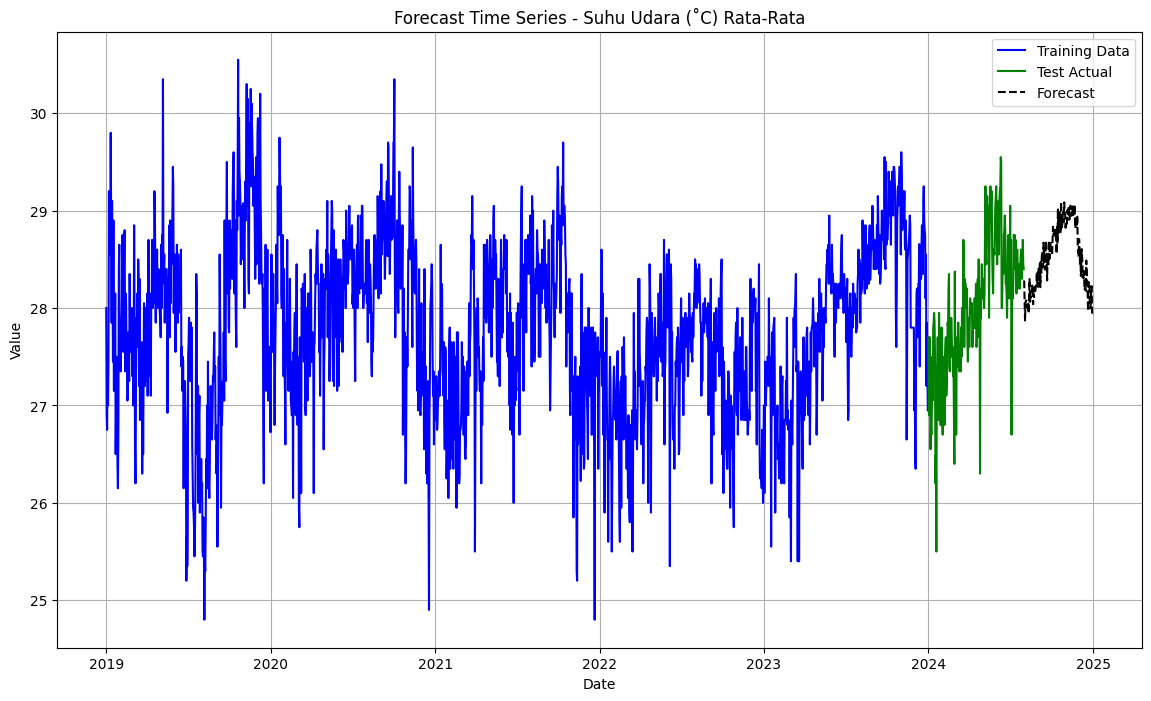

In [29]:
# Now, call the functions to visualize the data for each target feature
# Evaluation plot with test predictions
model_counter = 1
for target_feature in target_features:
    input_feature = target_feature

    print(f"Plotting Evaluation and Forecast for MLP Model {model_counter} - Target Feature: {target_feature}")

    # Define the actual and predicted test data for evaluation
    y_test_actual = df_test[target_feature].values  # True test values

    future_dates = pd.date_range(start='2024-08-01', end='2024-12-31')

    # Ambil data suhu dari bulan Juli 2024 sebagai input awal untuk peramalan masa depan
    X_future = df_test[[input_feature]].iloc[-WINDOW_SIZE:]
    
    # Tambahkan lebih banyak data dari training ke test untuk sliding window
    extra_data_X = df_train[[input_feature]].iloc[-WINDOW_SIZE:]

    # Gabungkan data training dan testing, ambil WINDOW_SIZE terakhir
    X_future_combined = pd.concat([extra_data_X, X_future], axis=0).iloc[-WINDOW_SIZE:]

    # Normalize and predict future values
    X_future_normalized = scalers[f"scaler_X_{model_counter}"].transform(X_future_combined.values.reshape(-1, 1))
    X_future_reshaped = X_future_normalized.reshape(1, WINDOW_SIZE, 1) 
    y_future_forecast = models[f"mlp_model_{model_counter}"].predict(X_future_reshaped)

    # Denormalize future predictions
    y_future_forecast = scalers[f"scaler_y_{model_counter}"].inverse_transform(y_future_forecast).flatten()[:len(future_dates)]

    # Plot future forecast visualization
    plot_time_series_with_forecast(df_train, df_test, y_future_forecast, future_dates, input_feature, title="Forecast Time Series")
    
    model_counter += 1